In [1]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
from scipy.special import i0 as I0

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
from mpl_toolkits.mplot3d import axes3d

import imageio

# Ring

In [3]:
N_X, N_Y = 256, 256                     # MotionClouds texture size (px)

n_e = 360                               # number of excitatory nodes in a ring
n_i = 30                         # number of inhibitory nodes in a ring

e_radius = 1                            # radius of the excitatory ring
i_radius = .8                           # radius of the inhibitory ring

e_color = r'#E64B35'                    # excitatory color, https://nanx.me/ggsci/reference/pal_npg.html
i_color = r'#3C5488'                    # inhibitory color, https://nanx.me/ggsci/reference/pal_npg.html

s_mult = 8                              # size gain, relative to node coordinate
ring_spacing = 2.                       # spacing between the two rings


save = True                             # save the files ?
dpi = 800                               # 

In [4]:
rad = lambda n, rad : np.array([rad * np.cos(np.arange(0,n) * 2 * np.pi / n),
                                rad * np.sin(np.arange(0,n) * 2 * np.pi / n)])

e_xs, e_ys = rad(n_e, e_radius) # excitatory nodes coordinates
i_xs, i_ys = rad(n_i, i_radius) # inhibitory nodes coordinates 

lab_xs, lab_ys = rad(n_e, e_radius + .2 * e_radius) # neuron labels coordinates

In [5]:
def recurrent_connect(idx=180, n_arrows=40, i0_arrows=5, step_arrows=3, color=e_color,
                      xs=e_xs, ys=e_ys, yfrom_rectif=0., yto_rectif=-.03):
    '''
    Draws recurrent synapses using arc FancyArrowPatch
    '''

    style = "Simple,tail_width=0.2,head_width=4,head_length=3"
    kw = dict(arrowstyle=style, edgecolor=color)
    alphas = 1 / np.exp(np.linspace(0., 1, n_arrows))
    lspace = np.linspace(i0_arrows, n_arrows, n_arrows //
                         step_arrows, dtype=int)
    
    # Forward
    for i0, x in enumerate(lspace):
        arr = patches.FancyArrowPatch((xs[idx], ys[idx] + yfrom_rectif),
                                      (xs[idx+x], ys[idx+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' % .75,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)

    # And back
    for i0, x in enumerate(-lspace):
        arr = patches.FancyArrowPatch((xs[idx], ys[idx] + yfrom_rectif),
                                      (xs[idx+x], ys[idx+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' % -.75,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)

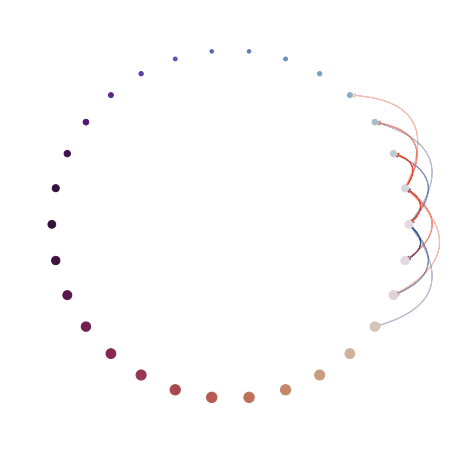

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

beg_i, end_i = 0.15, .9
scatter_map = plt.cm.twilight(np.linspace(0,1,n_i))

# Drawing the neural network --------------------------------------
ax.scatter(i_xs, i_ys, c = scatter_map,
           s=60*(-i_ys + np.abs(np.min(e_ys))),
           zorder=500)


# Recurrent connections
recurrent_connect(idx=0, n_arrows=3, i0_arrows=1, step_arrows=1, color=i_color,
                  xs=i_xs, ys=i_ys, yfrom_rectif=0., yto_rectif=0.)

recurrent_connect(idx=1, n_arrows=3, i0_arrows=1, step_arrows=1, color=e_color,
                  xs=i_xs, ys=i_ys, yfrom_rectif=0., yto_rectif=0.)

        
# Setting up the plot  ------------------------------------------
ax.set_xlim(-1., 1.)
ax.set_ylim(-1., 1.)
ax.axis('off')

fig.savefig('./figs/fig_model_ring.pdf', bbox_inches='tight', dpi=200, transparent=True)
plt.show()

# Kernel

In [7]:
def tuning_function(x, mu, kappa, fmax, bsl):
    # Von Mises, with kappa the concentration, mu the location, I0 Bessel order 0
    # fmax the firing rate at pref ori, bsl the min firing rate (not the baseline, which was substracted) 
    tf = np.exp((kappa)*np.cos((x-mu)))#/(2*np.pi*I0(kappa))
    tf = norm_data(tf)
    tf *= fmax
    tf += bsl
    return tf

def fit_tc(array, init_kappa):
    x = np.linspace(-np.pi, np.pi, len(array))
    y = array
    
    mod = Model(tuning_function)
    pars = Parameters()
    pars.add_many(('mu', 0, False, 0., np.pi),
                  ('kappa', init_kappa, True,  .1, 60.),
                  ('fmax', np.max(array), False, 0.01, np.max(array)),
                 ('bsl', np.min(array), False, 0.0, np.max(array)))

    out = mod.fit(y, pars, x=x, nan_policy='omit')

    return out.best_values

In [8]:
def make_kernel(kappae, kappai) :
    # making the probabilistic connection patterns
    exc_prob = tuning_function(orientation_space, 0, kappae, 1, 0)
    exc_prob /= np.sum(exc_prob)
    inh_prob = tuning_function(orientation_space, 0, kappai, 1, 0)
    inh_prob /= np.sum(inh_prob)
    
    return exc_prob, inh_prob

In [9]:
def norm_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [10]:
n = 256# number of neurons
duration = 150 # ms
orientation_space = np.linspace(-np.pi, np.pi, n)

alpha = 10.6 #gain of voltage to FR
Rrest = 0 # resting firing rate
tau = 10.8 # membrane time constant (ms)
dt = 1 # simulation step time

Jlgn = 9.57
Je, Ji = 1.71, 2.0178 # see notebook on notability for the maths
kappae, kappai  = 1.59, 1.16
kappa_lgn = 1.56

In [11]:
prob_e, prob_i = make_kernel(6, 3)
prob_e *= Je
prob_i *= Ji

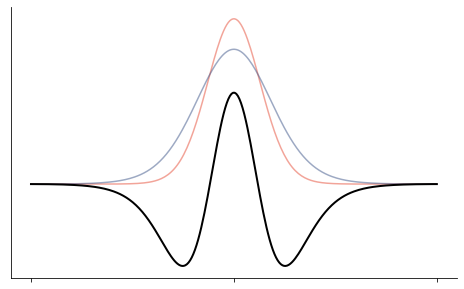

In [12]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(orientation_space, prob_e/3, color = e_color, alpha = .5) # scale down looks better
ax.plot(orientation_space, prob_i/3, color = i_color, alpha = .5)
ax.plot(orientation_space, prob_e - prob_i, color = 'k', lw = 2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_yticks([])
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([])

fig.savefig('./figs/fig_proba.pdf', bbox_inches='tight', dpi=200, transparent=True)
plt.show()

# voltage

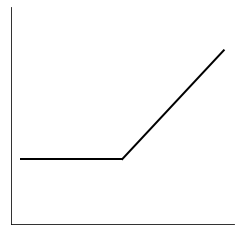

In [13]:
fig, ax = plt.subplots(figsize = (4,4))

ax.plot(np.linspace(-1,0, 100), np.linspace(0,10e-10, 100), color = 'k', lw = 2)

ax.plot(np.linspace(0,1, 100), np.linspace(0,.5, 100), color = 'k', lw = 2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(-.3,.7)

fig.savefig('./figs/fig_NL.pdf', bbox_inches='tight', dpi=200, transparent=True)
plt.show()

# RF

In [15]:
def kappa_to_hwhh(kappa) :
    # # See equation seven https://academic.oup.com/cercor/article/13/3/225/355481#5079220
    # Only works for kappa > 0.3467
    #hwhh = .5*np.arccos(1+ np.log((1+np.exp(-2*kappa))/2)/kappa)
    #hwhh = hwhh * 180 / np.pi
    #hwhh = np.arccos((np.log(.5) + kappa) / kappa) * 180 / np.pi
    hwhh = .5 * np.arccos( (np.log(.5)+kappa)/kappa) * 180 /np.pi
    return hwhh

def hwhh_to_btheta(hwhh) :
    # Quoth https://github.com/NeuralEnsemble/MotionClouds/blob/master/MotionClouds/MotionClouds.py#L246
    # HWHH = np.sqrt(2*Bt**2*np.log(2))
    # HWHH**2 = 2*Bt**2*np.log(2)
    # (HWHH**2)/2 = Bt**2*np.log(2)
    # (HWHH**2)/(2*np.log(2)) = Bt**2
    # Bt = np.sqrt((HWHH**2)/(2*np.log(2)))
    bt = hwhh**2
    bt = bt / 2
    bt = bt / np.log(2)
    bt = np.sqrt(bt)
    return bt # in degrees, if the input is in degree

def kappa_to_btheta(kappa) :
    hwhh = kappa_to_hwhh(kappa)
    btheta = hwhh_to_btheta(hwhh)
    return hwhh

In [20]:
kappas_lgns = np.linspace(20, .05, 50) # 10 to 36° of HWHH, it's what we have in the data
kappa_to_hwhh(kappas_lgns)

<ipython-input-15-d1db0b49c1d2>:7: RuntimeWarning: invalid value encountered in arccos
  hwhh = .5 * np.arccos( (np.log(.5)+kappa)/kappa) * 180 /np.pi


array([ 7.5642819 ,  7.64293597,  7.72409583,  7.80789741,  7.89448722,
        7.98402339,  8.0766769 ,  8.17263295,  8.27209252,  8.37527415,
        8.48241593,  8.59377787,  8.70964449,  8.83032794,  8.9561715 ,
        9.08755372,  9.22489321,  9.36865425,  9.5193534 ,  9.67756737,
        9.84394228, 10.01920479, 10.20417554, 10.39978531, 10.60709482,
       10.82731904, 11.06185726, 11.3123307 , 11.5806299 , 11.86897515,
       12.17999433, 12.51682447, 12.88324607, 13.28386342, 13.72435088,
       14.21179552, 14.75518425, 15.36611357, 16.05985281, 16.85699044,
       17.7860833 , 18.88812239, 20.22450083, 21.89228125, 24.05628833,
       27.02562898, 31.47306407, 39.28964872, 60.54083804,         nan])

In [21]:
tuning_function?

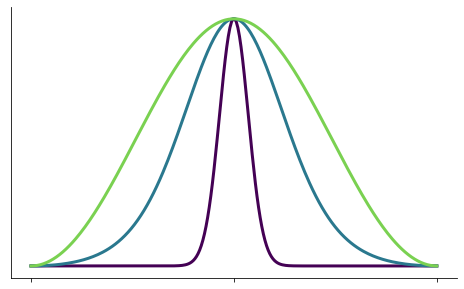

In [31]:
fig, ax = plt.subplots(figsize = (8,5))

cols = plt.cm.viridis(np.linspace(0., .8, 3))

for ik, kappa_plot in enumerate(kappas_lgns[[0, 45, -1]]) :
    ax.plot(orientation_space,
            tuning_function(x = orientation_space, mu = 0, 
                            kappa = kappa_plot, fmax = 1, bsl = 0),
           lw = 3, color = cols[ik]) 


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_yticks([])
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([])

fig.savefig('./figs/fig_rfs.pdf', bbox_inches='tight', dpi=200, transparent=True)
plt.show()